In [1]:
# autoreload to reload modules when they change
%load_ext autoreload
%autoreload 2

import rollout
from torch import optim
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

In [3]:
d_model = 64
n_tokens = 10
sequence_length = 6
n_heads = 1
dataset = rollout.dataset.InductionDataset(n_tokens, sequence_length)
simpleModel = rollout.models.FlexibleTransformer(d_model, n_tokens, sequence_length, n_heads, n_attn_layers=1)
optimizer = optim.AdamW(simpleModel.parameters(), lr=0.001)
criterion = nn.functional.cross_entropy

simple_train_losses, simple_test_losses = rollout.models.optimize_model(simpleModel, criterion, optimizer, dataset, n_epochs=500, batch_size=1024)

Epoch 0: Train Loss: 2.624439001083374, Test Loss: 2.5353057384490967
Epoch 100: Train Loss: 1.523861050605774, Test Loss: 1.5410751104354858
Epoch 200: Train Loss: 1.2865190505981445, Test Loss: 1.2643046379089355
Epoch 300: Train Loss: 1.2297629117965698, Test Loss: 1.2524868249893188
Epoch 400: Train Loss: 1.2351140975952148, Test Loss: 1.2593739032745361


In [5]:
d_model = 64
n_heads = 1

complexModel = rollout.models.FlexibleTransformer(d_model, n_tokens, sequence_length, n_heads, n_attn_layers=2)
optimizer = optim.AdamW(complexModel.parameters(), lr=0.001)
criterion = nn.functional.cross_entropy

complex_train_losses, complex_test_losses =  rollout.models.optimize_model(complexModel, criterion, optimizer, dataset, n_epochs=500, batch_size=1024)

Epoch 0: Train Loss: 2.5953800678253174, Test Loss: 2.456590414047241
Epoch 100: Train Loss: 0.003615314606577158, Test Loss: 0.003364869160577655
Epoch 200: Train Loss: 0.0008607349591329694, Test Loss: 0.0009148723911494017
Epoch 300: Train Loss: 0.0004577619256451726, Test Loss: 0.00047993537737056613
Epoch 400: Train Loss: 0.00029186750180087984, Test Loss: 0.0003077241126447916


In [6]:
num_simple_params = sum(p.numel() for p in simpleModel.parameters() if p.requires_grad)
num_complex_params = sum(p.numel() for p in complexModel.parameters() if p.requires_grad)
print(f"Simple model has {num_simple_params} parameters")
print(f"Complex model has {num_complex_params} parameters")

Simple model has 17674 parameters
Complex model has 34058 parameters


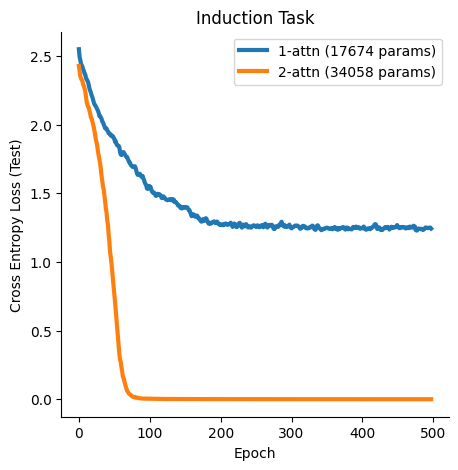

In [7]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(rollout.utils.movmean(np.array(simple_train_losses), 3), label=f"1-attn ({num_simple_params} params)", lw=3)
ax.plot(rollout.utils.movmean(np.array(complex_test_losses), 3), label=f"2-attn ({num_complex_params} params)", lw=3)
ax.set_ylabel("Cross Entropy Loss (Test)")  
ax.legend()
ax.set_title("Induction Task")
ax.set_xlabel("Epoch")
sns.despine()

In [8]:
X, y = dataset.generate_batch(100, type="test")

simple_x, simple_weights = simpleModel.forward_with_weights(X)
complex_x, complex_weights = complexModel.forward_with_weights(X)
y_pred_simple = torch.argmax(simple_x, dim=1)
y_pred_complex = torch.argmax(complex_x, dim=1)

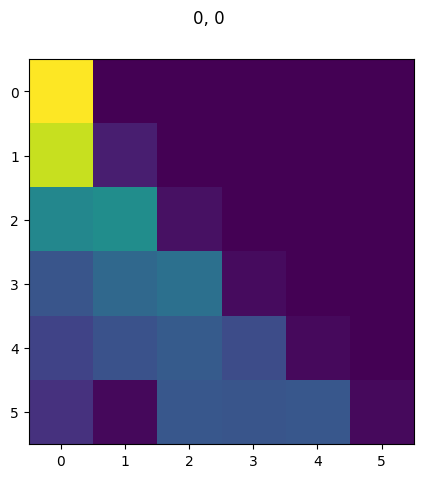

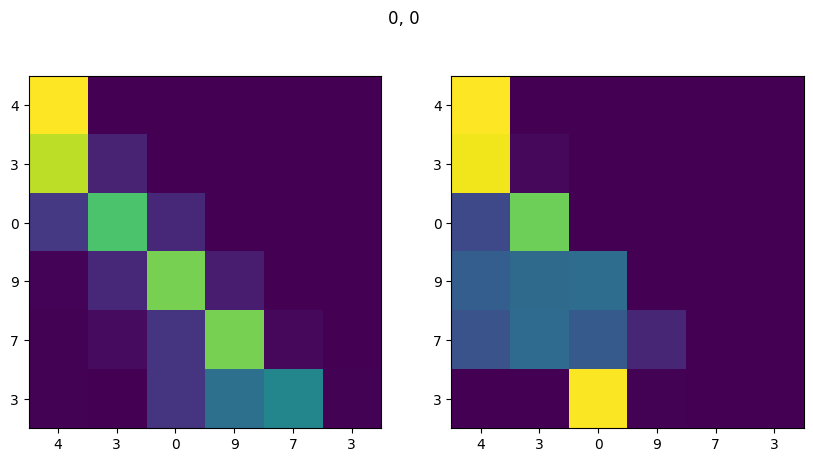

In [9]:
sample = np.random.randint(0, len(y))


fig, ax = plt.subplots(1, len(simple_weights), figsize=(10, 5))
for ix, aw in enumerate(simple_weights):
    plt.imshow(aw[sample])
fig.suptitle(f"{y[sample]}, {y_pred_simple[sample]}")

fig, ax = plt.subplots(1, len(complex_weights), figsize=(10, 5))
for ix, aw in enumerate(complex_weights):
    ax[ix].imshow(aw[sample])
    ax[ix].set_xticks(np.arange(sequence_length), labels=X[sample].numpy())
    ax[ix].set_yticks(np.arange(sequence_length), labels=X[sample].numpy())

fig.suptitle(f"{y[sample]}, {y_pred_complex[sample]}")
plt.show()

In [20]:
QKV = rollout.utils.get_QKV(complexModel.attention_layers[0], d_model=64)
sample_all = torch.ones((10, 6), dtype=torch.long)*11
pos_all = np.zeros([10, 6])
for i in range(6):
    pos_all[:, i] = i

for i in range(10):
    sample_all[i, :] = i

num_idx = sample_all.detach().numpy().reshape(-1, 1).ravel()
pos_idx = pos_all.reshape(-1, 1).ravel()

embedding = rollout.utils.embed_proj(complexModel, sample_all.unsqueeze(0)).squeeze(0)
Q_proj = torch.einsum("ab, ...b -> ...a", QKV["Q"], embedding)
K_proj = torch.einsum("ab, ...b -> ...a", QKV["K"], embedding)
V_proj = torch.einsum("ab, ...b -> ...a", QKV["V"], embedding)

In [21]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=60)
pca_out = pca_model.fit_transform(np.vstack([mat.detach().numpy().reshape(-1, d_model) for mat in [embedding, Q_proj, K_proj, V_proj]]))
n_token_x_pos = num_idx.shape[0]
embed_pca = pca_out[:n_token_x_pos]
Q_pca = pca_out[n_token_x_pos:2*n_token_x_pos]
K_pca = pca_out[2*n_token_x_pos:3*n_token_x_pos]
V_pca = pca_out[3*n_token_x_pos:]

n_relevant_dims = np.where(np.cumsum(pca_model.explained_variance_ratio_) > 0.9)[0][0]

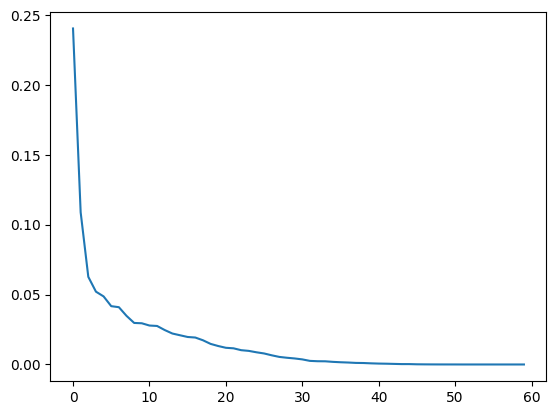

In [73]:
plt.plot(pca_model.explained_variance_ratio_)

In [86]:
Q_proj.shape

torch.Size([10, 6, 64])

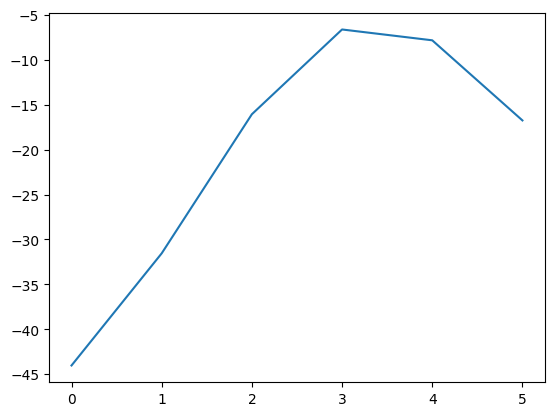

In [102]:
num = 1
pos = 5
plt.plot(np.array([(Q_proj[num, pos] @ K_proj[num, k_pos]).detach().numpy() for k_pos in range(6)]))

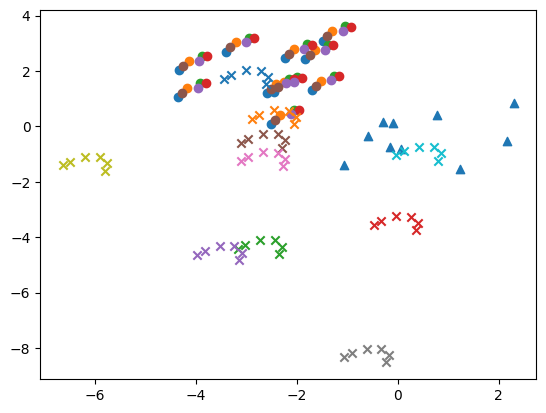

In [ ]:
d1, d2 = 1, 2
q_i = 0
plt.scatter(Q_pca[pos_idx == q_i, d1], Q_pca[pos_idx == q_i, d2], c="C0", marker="^")
for i in range(6):
    plt.scatter(K_pca[pos_idx == i, d1], K_pca[pos_idx == i, d2], c=f"C{i}")

#d1, d2 = 0, 1

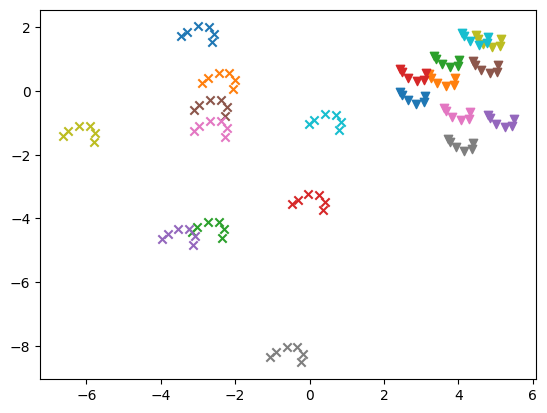

In [167]:


for i in range(10):
    plt.scatter(embed_pca[num_idx == i, d1], embed_pca[num_idx == i, d2], c=f"C{i}", marker="v")

for i in range(10):
    plt.scatter(V_pca[num_idx == i, d1], V_pca[num_idx == i, d2], c=f"C{i}", marker="x")

In [159]:
sample = torch.tensor([0, 1, 2, 3, 4, 5]).unsqueeze(0)

logits, attention, residuals = complexModel._fwd_internal(sample, return_weights=True, return_residuals=True)

In [168]:

token0_0 = residuals[0].squeeze(0)[4]
token0_1 = residuals[0].squeeze(0)[5]
token0_3 = residuals[0].squeeze(0)[3]
token1_1 = residuals[1].squeeze(0)[5]

In [169]:
(token0_0 @ token0_1), (token1_1 @ token0_1), (token0_0 @ (token0_1 - token1_1))

(tensor(42.7964, grad_fn=<DotBackward0>),
 tensor(91.5353, grad_fn=<DotBackward0>),
 tensor(12.7116, grad_fn=<DotBackward0>))

In [151]:
(token0_0 @ token0_3), (token0_3 @ token0_1)

(tensor(29.8966, grad_fn=<DotBackward0>),
 tensor(13.8944, grad_fn=<DotBackward0>))